## Naive Bayes Implementation

Referencias:
- http://artificiencia.com/aprenda/algoritmo-naive-bayes/
- https://chrisalbon.com/machine_learning/naive_bayes/naive_bayes_classifier_from_scratch/
- https://hackinganalytics.com/2016/10/13/desvendando-o-classificador-naive-bayes/
- https://towardsdatascience.com/naive-bayes-in-machine-learning-f49cc8f831b4

In [1]:
import pandas as pd
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import warnings
warnings.filterwarnings('ignore')


dataset = pd.read_csv('dataset/dataset.csv')

dataset.head(1)

,Genero,Idade,Escolaridade,Profissao,Target
0,F,a - Ate 25 anos,Fundamental,b,0


### Variaveis auxiliares

In [2]:

# Lista com todas as colunas menos Target
list_columns = list(dataset)
list_columns.pop()

# Lista de classes do target (0 e 1)
list_value_tg = list(dataset['Target'].unique())

### Estratégia adotada

De acordo com o proposto pelo trabalho, o algoritmo deveria rodar **30 vezes** e calcular Naive Bayes sendo que a cada interação deve-se embaralhar os datasets de treino e de teste, porem ao criar essa lógica tempo de execução disso, era cerca de **15 minutos** para cada 30 interações, após isso, teria o calculo da variação dos datasets de **80/20** até **20/80**, que dava um total de 60 interações, e cada interação ainda rodava o teste de 30 vezes, o que dava um total de 1800 interações do Naive Bayes sendo que o Naive Bayes interava o DataSet de teste inteiro para fazer o calculo, então fica claro que ele demorava muito tempo.
Analisando o código, identifiquei que além da quantidade de interações altissimas (que não dava para evitar), tinha outro gargalo nesse tempo que ele rodava, a consulta no ``Pandas`` era pouco perfomatica (eu utilizei o PANDAS para fazer operações com dataset) para executar, como ele fazia cerca de 25.000 consultas em um dataset de 1000 linhas ele demorava absurdos para executar. O motivo de tanta consulta era que, o algoritmo filtrava o dataset para fazer a contagem na criação da função ``P (A | h)``.

#### Solução

A cada vez que embaralhava o dataset, quando eu interava o dataset para calcular a probabilidade das classes de cada linha do dataset de teste, ele basicamente utilizava as mesmas operações, diversas vezes no mesmo dataset, então após embaralhar o dataset, eu crio um ``cache`` das operações em uma ``list`` para ao percorrer o dataset de teste, apenas consultar o cache ao inves de executar a operação do Naive Bayes.<br> 
+ A quantidade de consultas caiu de **25.000** para **36** (no caso desse dataset).
+ O tempo de execução dessa solução foi de **9 horas** de execução para **45 minutos**.


### Funções auxiliares
- P(A | B):
    - Função auxiliar para fazer `probabilidade condicional`
- P(A):
    - Função auxiliar para fazer `probabilidade` de classe/atributo

In [3]:
def load_ds_nb(ds):
    result = {}
    list_col = list(ds)
    list_col.pop(0)
    list_col.pop()

    list_val_tg = list(ds['Target'].unique())
    
    #Cache para P(h)
    for tg in list_val_tg:
        result['Target-'+str(tg)] = ds['Target'][ds['Target']==tg].count()/ds['Target'].count()
        
    #Cache para P (A| h)
    for col in list_col:
        list_value = list(ds[col].unique())
        for col_val in list_value:
            for tg in list_val_tg:
                result[col+'-'+str(col_val)+'-'+str(tg)] = ds[col][(ds[col]==col_val) & (ds['Target']==tg)].count()/ds['Target'][ds['Target']==tg].count()

    return result

In [4]:
def p_given_q(cache, p, q, val_p, val_q):
    return cache[p+'-'+str(val_p)+'-'+str(val_q)]

def p_q(cache, p,val_p):
    #ds[p][ds[p]==val_p].count()/ds[p].count()
    return cache[p+'-'+str(val_p)]

### Implementação do Classificador Naive Bayes
A função recebe a variavel ``Cache`` contendo a combinação das operações que irão ser utilizada para o calculo.

O algoritmo para implementar o Naive Bayes, foi utilizando interando todos o dataset de ``teste`` e fazendo a seguinte formula ``P(atributo_1 | classe) x P(atributo_2 | classe) ... P(atributo_n | classe) x P(classe)`` e para todas as classes utilizando o **Maximum Likelihood** para buscar a classe com maior probabilidade e predizer o resultado.
Com o resultado desse dado eu faço a verificação com cada dataset de teste da interação

In [5]:
def naive_bayes(cache, dataset_test):
    count_correct = 0
    count_incorrect = 0
    
    count_correct_zero = 0
    count_correct_one = 0
    count_incorrect_zero = 0
    count_incorrect_one = 0
    
    for index, row in dataset_test.iterrows():
        classes = list()
        
        # Essa repetição das operações foram feitas para ter menos interações e poder ser mais perfomatico.
        prob_zero  = p_q(cache,'Target',0)
        prob_zero *= p_given_q(cache,'Genero','Target',row['Genero'],0)
        prob_zero *= p_given_q(cache,'Idade','Target',row['Idade'],0)
        prob_zero *= p_given_q(cache,'Escolaridade','Target',row['Escolaridade'],0)
        prob_zero *= p_given_q(cache,'Profissao','Target',row['Profissao'],0)
            
        prob_one  = p_q(cache,'Target',1)
        prob_one *= p_given_q(cache,'Genero','Target',row['Genero'],1)
        prob_one *= p_given_q(cache,'Idade','Target',row['Idade'],1)
        prob_one *= p_given_q(cache,'Escolaridade','Target',row['Escolaridade'],1)
        prob_one *= p_given_q(cache,'Profissao','Target',row['Profissao'],1)

        #Result
        classes = [(0, prob_zero), (1, prob_one)]
        
        result = max(classes, key=lambda p: p[1])
        if result[0] == row['Target']:
            count_correct += 1
            if result[0] == 0:
                count_correct_zero += 1
            else:
                count_correct_one += 1
        else:
            count_incorrect += 1
            if result[0] == 0:
                count_incorrect_zero += 1
            else:
                count_incorrect_one += 1
    return (count_correct, count_incorrect, count_correct_zero, count_correct_one, count_incorrect_zero, count_incorrect_one)

### Treinar e testar

Função que irá interar ``number`` vezes usando a função ``Naive Bayes`` e retornar os arrays contendo porcentagens de acerto.

A cada interação ele embaralha o dataset aleatóriamente e divide ele em uma porcentagem (o proprio pandas faz isso) setada na assinatura da função.

In [6]:
def run_nth(percentage, number):
    percentages_correct = list()
    prob_correct_zero = list()
    prob_correct_one = list()
    
    for i in range(0,number):

        # Essa função pega o dataset e separa uma fração dele, e reordena
        ds_train=dataset.sample(frac=percentage, random_state=i*randint(0,100)).reset_index()
        ds_test=dataset.drop(ds_train.index) # Pega o que sobrou do dataset de treino
        
        #Cria cache para Naive Bayes
        cache = load_ds_nb(ds_train)
        
        correct, incorrect, correct_zero, correct_one, incorrect_zero, incorrect_one = naive_bayes(cache, ds_test)

        if (correct_zero+incorrect_zero) != 0:
            prob_correct_zero.append(correct_zero/(correct_zero+incorrect_zero))
        
        if (correct_one+incorrect_one) != 0:
            prob_correct_one.append(correct_one/(correct_one+incorrect_one))
        
        percentages_correct.append(correct/(correct+incorrect))
    
        
    return (percentages_correct, prob_correct_zero, prob_correct_one)

### Trata o resultado do treino e teste
Faz o calculo da porcentagem de acordo com a quantidade de corretas e incorretas

In [7]:
percents, prob_zero, prob_one = run_nth(0.8,30)

### Taxa de Acerto

In [8]:
taxa_acerto_min=np.min(percents)
taxa_acerto_max=np.max(percents)
taxa_acerto_med=np.mean(percents)

print('Taxa de Acerto')
print('------------------')
print('Minimo: ' + str(taxa_acerto_min))
print('Máxima: ' + str(taxa_acerto_max))
print('Média: '+str(taxa_acerto_med))

Taxa de Acerto
------------------
Minimo: 0.775
Máxima: 0.79
Média: 0.7820000000000003


### Taxa de Acerto Médio por Classe

In [9]:
taxa_acerto_zero = np.mean(prob_zero)
taxa_acerto_one = np.mean(prob_one)

print('Taxa de Acerto Médio por classe')
print('------------------')
print('Classe 0: ' + str(taxa_acerto_zero))
print('Classe 1: ' + str(taxa_acerto_one))

Taxa de Acerto Médio por classe
------------------
Classe 0: 0.7000326797385622
Classe 1: 0.79130528923656


### Produzir os dados para gerar o gráfico
Nessa parte ele interaje de **80/20** até **20/80** os datasets de treino e teste, a cada porcentagem ele calcula as medias de probabilidade de acerto 30 vezes.

**OBS: ESSE TRECHO DEMORA CERCA DE 30 minutos para executar.**

In [10]:
mean_percents = list()
percents_axis = list()
for n in range(20,81):
    p, pc, pi = run_nth(n/100, 30)
    mean_percents.append(np.mean(p))
    percents_axis.append(n)
    

### Gráfico de acerto
Gráfico contendo a ``Probabilidade de acerto X Porcentagem do dataset de treino``.


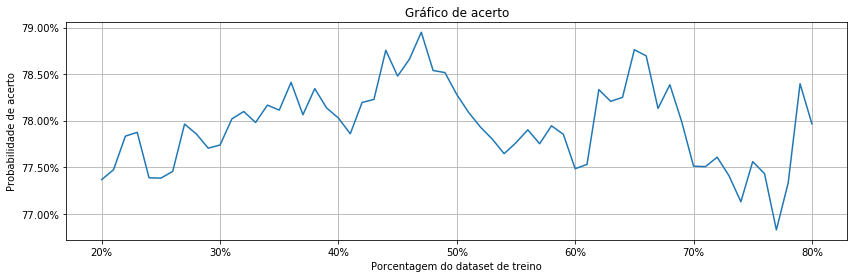

In [16]:
fig = plt.figure(1, (14,4))
ax = fig.add_subplot(1,1,1)
percents_axis = [x / 100 for x in percents_axis]
ax.plot(percents_axis, mean_percents)
ax.set_title('Gráfico de acerto')

ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.set_ylabel('Probabilidade de acerto')

ax.set_xlabel('Porcentagem do dataset de treino')

plt.grid(True)
plt.show()

Para cada porcentagem do dataset de treino, o restante dos dados foram utilizado para teste.
Por exemplo, caso eu tenhoa usado 20% para treino, 80% foram utilizado para teste (Não está explicito no gráfico)